# Optimization of a DRRP
_written by Jaren N. Ashcraft_

In 2002 Matthew H. Smith published their seminal paper on the formal optimization of the Dual Rotating Retarder Mueller matrix Polarimeter (DRRP). In this tutorial, we use `Katsu` to recreate the work in their paper. Users can look to the [Full Mueller Polarimetry](FullMuellerExample.ipynb) demo to learn about the DRRP, the basics of which will not be discussed here.

In [260]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from katsu.mueller import linear_diattenuator, linear_retarder
from katsu.polarimetry import condition_number, drrp_data_reduction_matrix
from katsu.katsu_math import np

# set up some colorblind-friendly plotting
plt.style.use('bmh')
okabe_colorblind8 = [
'#000000',
'#E69F00',
'#56B4E9',
'#009E73',
'#F0E442',
'#0072B2',
'#D55E00',
'#CC79A7',
]
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe_colorblind8)

Smith begins by introducing the polarimetric data reduction matrix, which is computed from the polarization state generator and analyzer matrices. Let's construct them below using `Katsu`. First let's set up our forward model to compute the condition number of the data reduction matrix $cond(\mathbf{W})$. This metric relates to how singular the data reduction matrix is.

In [261]:
def condition_number_drrp(nmeas, angles_g, angles_a, retardance_g, retardance_a, range=np.pi):


    psg_pol = linear_diattenuator(0, 0, shape=[nmeas])
    psg_qwp = linear_retarder(angles_g, retardance_g, shape=[nmeas])
    psg = psg_qwp @ psg_pol

    psa_qwp = linear_retarder(angles_a, retardance_a, shape=[nmeas])
    psa_pol = linear_diattenuator(0, 0, shape=[nmeas])
    psa = psa_pol @ psa_qwp

    W_matrix = drrp_data_reduction_matrix(psg, psa)

    return condition_number(W_matrix)

Let us first examine the influence of retarders on the condition number for an exactly-specified DRRP measurement. This means that we only take 16 measurements, which is the minimum necessary to perform Mueller polarimetry.

In [262]:
N_MEASUREMENTS = 16
ANGULAR_RATIO = 5

retardances = np.linspace(0, 2 * np.pi, 1000)
angles_g = np.linspace(0, np.pi, N_MEASUREMENTS)
angles_a = ANGULAR_RATIO * angles_g
cond_w = []

for ret in retardances:

    cond_w.append(condition_number_drrp(N_MEASUREMENTS, angles_g, angles_a, ret, ret))

We plot the results below, where we find that the minimum condition number is for a $\lambda / 3$ waveplate. This is the first big result of Smith's paper.

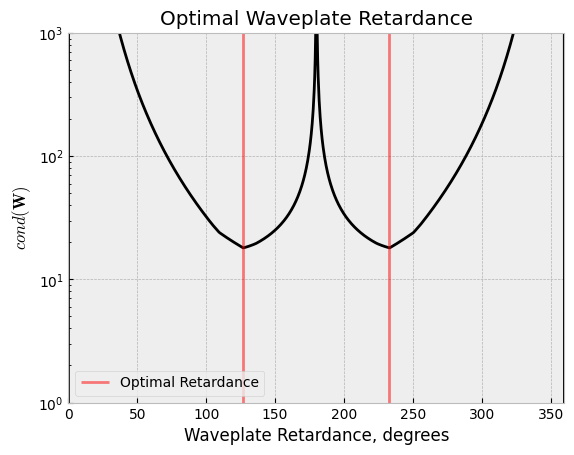

In [263]:
plt.figure()
plt.plot(np.degrees(retardances), cond_w, color='black')
plt.xlabel('Waveplate Retardance, degrees')
plt.ylabel(r'$cond(\mathbf{W})$')
plt.title('Optimal Waveplate Retardance')
plt.yscale('log')
plt.xlim([0, 360])
plt.ylim([1, 1e3])
plt.vlines([127, 360-127], 0, 1e3, linewidth=2, alpha=0.5, color='red', label='Optimal Retardance')
plt.legend()
plt.show()

Next we want to explore the impact of the relative angular increment of the rotating retarders by plotting the condition numbers with respect to different angular increments of the polarization state generator and analyzer.

In [264]:
N_MEASUREMENTS = 16
optimal_ret = 2 * np.pi / 3
Npts = 256
angular_increments = np.linspace(0, np.radians(90), Npts)
cond_w = np.zeros([Npts, Npts])

for i, tg in enumerate(angular_increments):
    for j, ta in enumerate(angular_increments):

        angles_g = np.linspace(0, N_MEASUREMENTS * angular_increments[i], N_MEASUREMENTS)
        angles_a = np.linspace(0, N_MEASUREMENTS * angular_increments[j], N_MEASUREMENTS)

        cond_w[i, j] = condition_number_drrp(N_MEASUREMENTS, angles_g, angles_a, optimal_ret, optimal_ret)


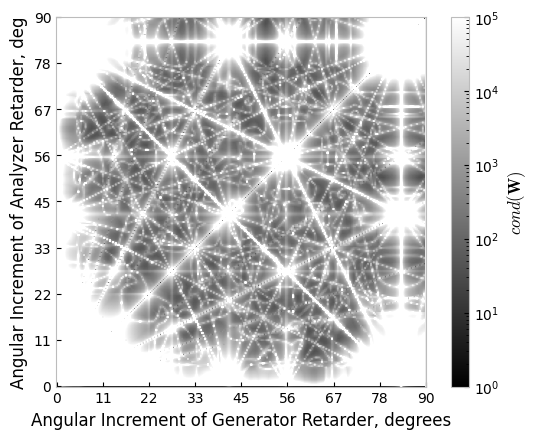

In [268]:
ticks = np.arange(0, Npts+32, 32)
ticklabels = np.linspace(0, 90, len(ticks)).astype(int)

plt.figure()
plt.imshow(cond_w, origin='lower', norm=LogNorm(vmin=1, vmax=1e5), cmap='gray')
plt.xticks(ticks, ticklabels)
plt.yticks(ticks, ticklabels)
plt.ylabel('Angular Increment of Analyzer Retarder, deg')
plt.xlabel('Angular Increment of Generator Retarder, degrees')
plt.colorbar(label=r'$cond(\mathbf{W})$')
plt.grid(False)
plt.show()

This result is for 16 measurements, and is a very complex solution space. What happens if we up the measurements with $N = 30$?

In [269]:
N_MEASUREMENTS = 30
optimal_ret = 2 * np.pi / 3
Npts = 256
angular_increments = np.linspace(0, np.radians(90), Npts)
cond_w = np.zeros([Npts, Npts])

for i, tg in enumerate(angular_increments):
    for j, ta in enumerate(angular_increments):

        angles_g = np.linspace(0, N_MEASUREMENTS * angular_increments[i], N_MEASUREMENTS)
        angles_a = np.linspace(0, N_MEASUREMENTS * angular_increments[j], N_MEASUREMENTS)

        cond_w[i, j] = condition_number_drrp(N_MEASUREMENTS, angles_g, angles_a, optimal_ret, optimal_ret)


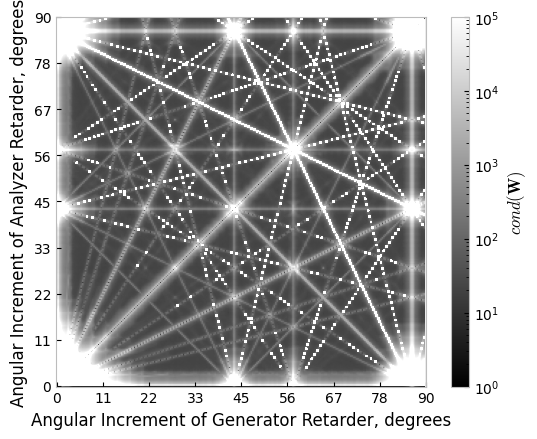

In [270]:
plt.figure()
plt.imshow(cond_w, origin='lower', norm=LogNorm(vmin=1, vmax=1e5), cmap='gray')
plt.xticks(ticks, ticklabels)
plt.yticks(ticks, ticklabels)
plt.ylabel('Angular Increment of Analyzer Retarder, degrees')
plt.xlabel('Angular Increment of Generator Retarder, degrees')
plt.colorbar(label=r'$cond(\mathbf{W})$')
plt.grid(False)
plt.show()

This essentially shows that more measurements allow for a greater landscape of solutions that are likely to return a good reconstruction. The following was not in Smith's paper, but `Katsu` goes so fast it's not too big of a problem to go to $N = 100$

In [271]:
N_MEASUREMENTS = 100
optimal_ret = 2 * np.pi / 3
Npts = 256
angular_increments = np.linspace(0, np.radians(90), Npts)
cond_w = np.zeros([Npts, Npts])

for i, tg in enumerate(angular_increments):
    for j, ta in enumerate(angular_increments):

        angles_g = np.linspace(0, N_MEASUREMENTS * angular_increments[i], N_MEASUREMENTS)
        angles_a = np.linspace(0, N_MEASUREMENTS * angular_increments[j], N_MEASUREMENTS)

        cond_w[i, j] = condition_number_drrp(N_MEASUREMENTS, angles_g, angles_a, optimal_ret, optimal_ret)


This took about 13.6s on my M1 Macbook pro, not too bad for brute-forcing a solution-space!

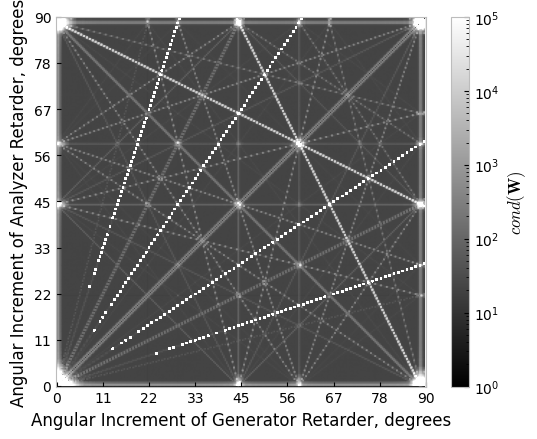

In [272]:
plt.figure()
plt.imshow(cond_w, origin='lower', norm=LogNorm(vmin=1, vmax=1e5), cmap='gray')
plt.xticks(ticks, ticklabels)
plt.yticks(ticks, ticklabels)
plt.ylabel('Angular Increment of Analyzer Retarder, degrees')
plt.xlabel('Angular Increment of Generator Retarder, degrees')
plt.colorbar(label=r'$cond(\mathbf{W})$')
plt.grid(False)
plt.show()

Smith's last goal was the optimization of the angular velocity ratio between the PSA and PSG given a set number of measurements. They did it for $\lambda/3$ waveplates, but I was interested in recreating the experiment for quarter-wave plates. 

In [277]:
N_MEASUREMENTS = 120

angular_ratios = np.linspace(0, 10, 1000)
optimal_ret = 2 * np.pi / 3
angular_increments = np.linspace(0, np.radians(360), N_MEASUREMENTS)
cond_w_opt = []
cond_w_qwp = []
cond_w_hwp = []

for tr in angular_ratios:

    angles_g = angular_increments
    angles_a = tr * angular_increments

    cond_w_opt.append(condition_number_drrp(N_MEASUREMENTS, angles_g, angles_a, optimal_ret, optimal_ret))
    cond_w_qwp.append(condition_number_drrp(N_MEASUREMENTS, angles_g, angles_a, np.pi/2, np.pi/2))
    cond_w_hwp.append(condition_number_drrp(N_MEASUREMENTS, angles_g, angles_a, np.pi, np.pi))


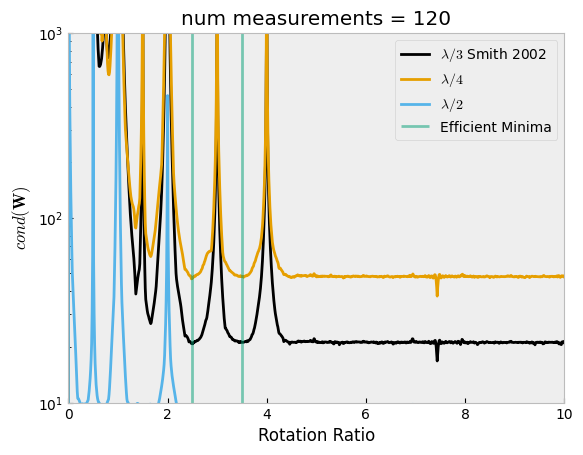

In [283]:
plt.figure()
plt.plot(angular_ratios, cond_w_opt, label=r'$\lambda/3$'+' Smith 2002')
plt.plot(angular_ratios, cond_w_qwp, label=r'$\lambda/4$')
plt.plot(angular_ratios, cond_w_hwp, label=r'$\lambda/2$')

# plot some of the minima
plt.vlines([2.5, 3.5], 0, 1e3, linewidth=2, alpha=0.5, color=okabe_colorblind8[3], label='Efficient Minima')

# labeling
plt.title(f'num measurements = {N_MEASUREMENTS}')
plt.ylabel(r'$cond(\mathbf{W})$')
plt.xlabel('Rotation Ratio')
plt.yscale('log')
plt.xlim([0, 10])
plt.ylim([1e1, 1e3])
plt.legend()
plt.grid(False)
plt.show()

It turns out that the ratios of 1:1, 1.5:1, 2:1, 3:1, and 4:1 result in singular data reduction matrices, These corresond the the splikes shown in this plot. Interestingly, there is a very efficient minimum. Interestingly, the half-wave retardance is very well conditioned. However, all projections of polarization onto the circular basis lie in the null space of the polarimeter, so it is not a truly "Full Mueller" polarimeter. Consequently, the condition number tells us _nothing_ about the sensitivity to all polarization states. More likely, it tells us about the sensitivity to the polarization states that the polarimeter can measure.

# DRRP Optimization Given Sub-optimal Hardware

The Dual-rotating Retarder Mueller Polarimeter is a critical architecture for determining the Mueller matrix of a given sample. This configuration is commonly used in laboratories across the world, and substantial work has been done in its optimization. Most notably, Smith's seminal work in the optimization of the DRRP explored the optimal waveplate retardance and rotation ratios for a Mueller polarimeter that minimizes the condition number of the data reduction matrix.

However, $\lambda/3$ wave plates are substantially less accessible than $\lambda / 4$ waveplates commercially. In Table 1 we review some commercially available options for retarders. Note that none of the commercial-off-the-shelf (COTS) vendors have the capacity to produce a $\lambda/3$ waveplate. Newport and BVO have an option for a liquid crystal variable retarder, which can theoretically achieve $\lambda/3$ optimal retardance. However, the cost is an order of magnitude greater than COTS zero-order $\lambda/4$ waveplates.


|     | ThorLabs* | Newport* | Edmund Optics* | Optosigma* | Boulder Vision Optik (BVO)*** |
| --- | --- | --- | --- | --- | --- |
| $\lambda/4$ Zero-order Waveplate | $321.92 | $477 | $665.00 | $699.00 | Available |
| $\lambda/4$ Achromatic Waveplate | $1029.93 | $1,601 | $1,100.00 | $1,497.00 | Available |
| $\lambda/3$ Waveplate | Not Available | Not Available | Not Available | Not Available | Not Available | 
| Variable Retarder** | Not Available | $2,278 | Not Available | Not Available | Available | 
* pricing based on Fall 2024 pricing

** contingent on the retarder being able to achieve $\lambda/3$ retardance

*** Pricing is by quote request, and is likely higher than the COTS equivalents

For investigators without access to substantial funding, such as new laboratories seeking grant funding, or startup companies, a substantial amount of resources could be saved by optimizing the DRRP with the constraint of using $\lambda/4$ waveplates. In this letter, we review Smith's optimization procedure with this constraint and the relative accuracy of the waveplate.

Since we impose the quarter-wave constraint on the DRRP, we skip the "optimal" retardance step in Smith's paper, and re-create the ensuing results with this constraint.

In [305]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import matplotlib as mpl
from katsu.mueller import linear_diattenuator, linear_retarder
from katsu.polarimetry import condition_number, drrp_data_reduction_matrix
from katsu.katsu_math import np

# set up some colorblind-friendly plotting
plt.style.use('bmh')
okabe_colorblind8 = ['#000000', '#E69F00', '#56B4E9', '#009E73',
                     '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe_colorblind8)

def condition_number_drrp(nmeas, angles_g, angles_a, retardance_g, retardance_a):


    psg_pol = linear_diattenuator(0, 0, shape=[nmeas])
    psg_qwp = linear_retarder(angles_g, retardance_g, shape=[nmeas])
    psg = psg_qwp @ psg_pol

    psa_qwp = linear_retarder(angles_a, retardance_a, shape=[nmeas])
    psa_pol = linear_diattenuator(0, 0, shape=[nmeas])
    psa = psa_pol @ psa_qwp

    W_matrix = drrp_data_reduction_matrix(psg, psa)

    return condition_number(W_matrix)

We begin by considering the angular increments for the $\lambda/3$ and $\lambda/4$ waveplate case for an exactly specified DRRP measurement, where the number of measurements ($N$) is equal to the number of elements of the Mueller matrix $N=16$.

In [287]:
N_MEASUREMENTS = 16
optimal_ret = 2 * np.pi / 3
suboptimal_ret = np.pi / 2
Npts = 256
angular_increments = np.linspace(0, np.radians(90), Npts)
cond_w_3 = np.zeros([Npts, Npts])
cond_w_4 = np.zeros([Npts, Npts])

for i, tg in enumerate(angular_increments):
    for j, ta in enumerate(angular_increments):

        angles_g = np.linspace(0, N_MEASUREMENTS * angular_increments[i], N_MEASUREMENTS)
        angles_a = np.linspace(0, N_MEASUREMENTS * angular_increments[j], N_MEASUREMENTS)

        cond_w_3[i, j] = condition_number_drrp(N_MEASUREMENTS, angles_g, angles_a, optimal_ret, optimal_ret)
        cond_w_4[i, j] = condition_number_drrp(N_MEASUREMENTS, angles_g, angles_a, optimal_ret, suboptimal_ret)

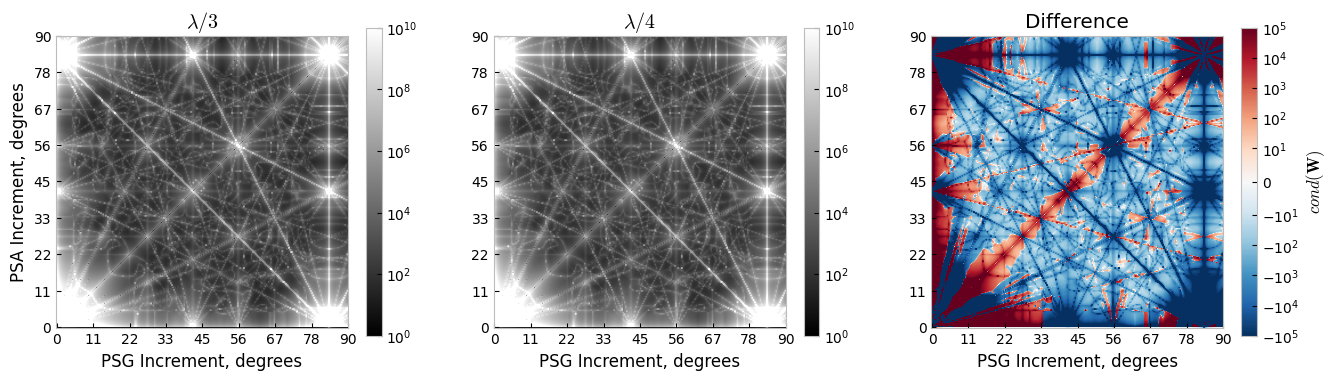

In [314]:
data = [cond_w_3, cond_w_4, cond_w_3 - cond_w_4]
titles = [r'$\lambda/3$',r'$\lambda/4$', 'Difference']

plt.figure(figsize=[16, 4])

for i, (cond_w, title) in enumerate(zip(data, titles)):

    plt.subplot(1,3,i+1)
    plt.title(title)
    if i < 2:
        im = plt.imshow(cond_w, origin='lower', norm=LogNorm(vmin=1, vmax=1e10), cmap='gray')
    else:
        im = plt.imshow(cond_w, origin='lower', norm=SymLogNorm(vmin=-1e5, vmax=1e5, linthresh=1e1), cmap='RdBu_r')
    plt.xticks(ticks, ticklabels)
    plt.yticks(ticks, ticklabels)
    if i == 0:
        plt.ylabel('PSA Increment, degrees')
    plt.xlabel('PSG Increment, degrees')
    if i < 2:
        plt.colorbar(im)
    else:
        plt.colorbar(im, label=r'$cond(\mathbf{W})$')
    plt.grid(False)
plt.show()

The solution space is simmilarly complex across both cases. On the right we look at the difference in a symmetric logarithm scale. On this map, the blue regions are the areas where the $\lambda/4$ polarimeter is worse than the $\lambda/3$ polarimeter. A majority of the solution space is less-optimal, by a condition number near the order of 10-50. However, in the case of some poorly-conditioned measurements, the $\lambda/4$ polarimeter may theoretically outperform the optimal case. These regions are shown in red.

Next we explore how much the solution space improves by going to a higher number of measurements, $N = 30$.

In [315]:
N_MEASUREMENTS = 30
optimal_ret = 2 * np.pi / 3
suboptimal_ret = np.pi / 2
Npts = 256
angular_increments = np.linspace(0, np.radians(90), Npts)
cond_w_3 = np.zeros([Npts, Npts])
cond_w_4 = np.zeros([Npts, Npts])

for i, tg in enumerate(angular_increments):
    for j, ta in enumerate(angular_increments):

        angles_g = np.linspace(0, N_MEASUREMENTS * angular_increments[i], N_MEASUREMENTS)
        angles_a = np.linspace(0, N_MEASUREMENTS * angular_increments[j], N_MEASUREMENTS)

        cond_w_3[i, j] = condition_number_drrp(N_MEASUREMENTS, angles_g, angles_a, optimal_ret, optimal_ret)
        cond_w_4[i, j] = condition_number_drrp(N_MEASUREMENTS, angles_g, angles_a, optimal_ret, suboptimal_ret)

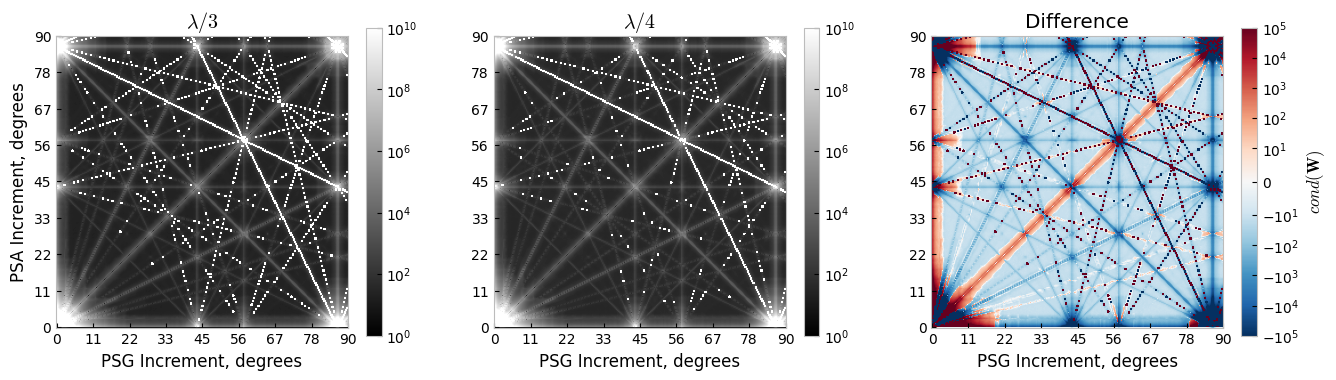

In [316]:
data = [cond_w_3, cond_w_4, cond_w_3 - cond_w_4]
titles = [r'$\lambda/3$',r'$\lambda/4$', 'Difference']

plt.figure(figsize=[16, 4])

for i, (cond_w, title) in enumerate(zip(data, titles)):

    plt.subplot(1,3,i+1)
    plt.title(title)
    if i < 2:
        im = plt.imshow(cond_w, origin='lower', norm=LogNorm(vmin=1, vmax=1e10), cmap='gray')
    else:
        im = plt.imshow(cond_w, origin='lower', norm=SymLogNorm(vmin=-1e5, vmax=1e5, linthresh=1e1), cmap='RdBu_r')
    plt.xticks(ticks, ticklabels)
    plt.yticks(ticks, ticklabels)
    if i == 0:
        plt.ylabel('PSA Increment, degrees')
    plt.xlabel('PSG Increment, degrees')
    if i < 2:
        plt.colorbar(im)
    else:
        plt.colorbar(im, label=r'$cond(\mathbf{W})$')
    plt.grid(False)
plt.show()

We observe that both solution spaces improve considerably for $N = 30$. In observing the difference, the average blue background maintains that the $\lambda/4$ polarimeter is less optimal. However, the magnitude of the difference is much smaller, being closer to a condition number of 10. This is consistent with Smith's result when exploring the theoretical condition number as a function of retardance. 

Next we illustrate the difference in angular ratios.

In [360]:
N_MEASUREMENTS = 30

angular_ratios = np.linspace(0, 10, 1000)
optimal_ret = 2 * np.pi / 3
angular_increments = np.linspace(0, np.radians(360), N_MEASUREMENTS)
angular_increments_40 = np.linspace(0, np.radians(360), 40)
angular_increments_50 = np.linspace(0, np.radians(360), 50)
angular_increments_100 = np.linspace(0, np.radians(360), 100)
cond_w_opt = []
cond_w_qwp_30 = []
cond_w_qwp_40 = []
cond_w_qwp_50 = []
cond_w_qwp_100 = []

for tr in angular_ratios:

    angles_g = angular_increments
    angles_a = tr * angular_increments
    cond_w_opt.append(condition_number_drrp(N_MEASUREMENTS, angles_g, angles_a, optimal_ret, optimal_ret))
    cond_w_qwp_30.append(condition_number_drrp(N_MEASUREMENTS, angles_g, angles_a, np.pi/2, np.pi/2))

    angles_g = angular_increments_40
    angles_a = tr * angular_increments_40
    cond_w_qwp_40.append(condition_number_drrp(40, angles_g, angles_a, np.pi/2, np.pi/2))

    angles_g = angular_increments_50
    angles_a = tr * angular_increments_50
    cond_w_qwp_50.append(condition_number_drrp(50, angles_g, angles_a, np.pi/2, np.pi/2))


    angles_g = angular_increments_100
    angles_a = tr * angular_increments_100
    cond_w_qwp_100.append(condition_number_drrp(100, angles_g, angles_a, np.pi/2, np.pi/2))


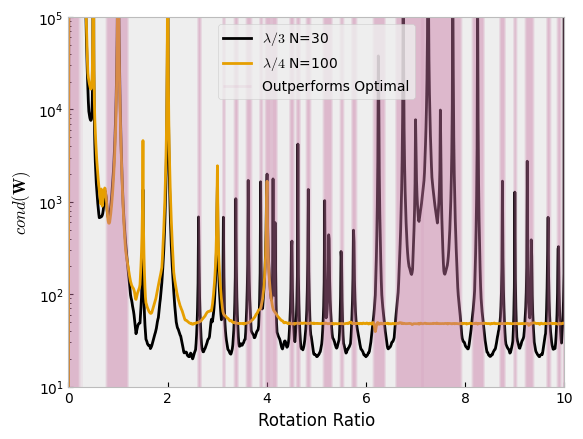

In [365]:
plt.figure()
plt.plot(angular_ratios, cond_w_opt, label=r'$\lambda/3$'+' N=30')
# plt.plot(angular_ratios, cond_w_qwp_30, label=r'$\lambda/4$'+' N=30')
# plt.plot(angular_ratios, cond_w_qwp_40, label=r'$\lambda/4$'+' N=40')
plt.plot(angular_ratios, cond_w_qwp_100, label=r'$\lambda/4$'+' N=100')

# plot some of the minima
angles_not_suboptimal = []
for i, ang in enumerate(angular_ratios):
    if cond_w_qwp_100[i] < cond_w_opt[i]:
        angles_not_suboptimal.append(ang)

plt.vlines(angles_not_suboptimal, 0, 1e5, linewidth=2, alpha=0.1, color=okabe_colorblind8[-1], label='Outperforms Optimal')

# labeling
plt.ylabel(r'$cond(\mathbf{W})$')
plt.xlabel('Rotation Ratio')
plt.yscale('log')
plt.xlim([0, 10])
plt.ylim([1e1, 1e5])
plt.legend()
plt.grid(False)
plt.show()